In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

jax.config.update("jax_enable_x64", True)



%matplotlib inline

c:\Users\dl277493\AppData\Local\miniforge3\envs\temgym\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sympy as sp

def calculate_object_plane(f, z2):
	return (1/f - 1/z2)**-1


def calculate_image_plane(f, z1):
	return (1/f + 1/z1)**-1


def calculate_focal_length(z1, z2):
	return (1/z1 + 1/z2)**-1

def propagation_matrix(d, xp=sp):
	if xp == sp:
		return xp.Matrix([[1, d], [0, 1]])
	else:
		return xp.array([[1, d], [0, 1]])


def thin_lens_matrix(f, xp=sp):
	if xp == sp:
		return xp.Matrix([[1, 0], [-1/f, 1]])
	else:
		return xp.array([[1, 0], [-1/f, 1]])

def imaging_matrix(M, f, xp=sp):
	if xp == sp:
		return xp.Matrix([[M, 0], [-1/f, 1/M]])
	else:
		return xp.array([[M, 0], [-1/f, 1/M]])
	
def diffraction_matrix(L, f, xp=sp):
	
	obj_prop_mat = propagation_matrix(L, xp)
	lens_mat = thin_lens_matrix(f, xp)
	f_prop_mat = propagation_matrix(f, xp)

	return f_prop_mat @ lens_mat @ obj_prop_mat


(817, 1398, 4)
0.0010204081632653062


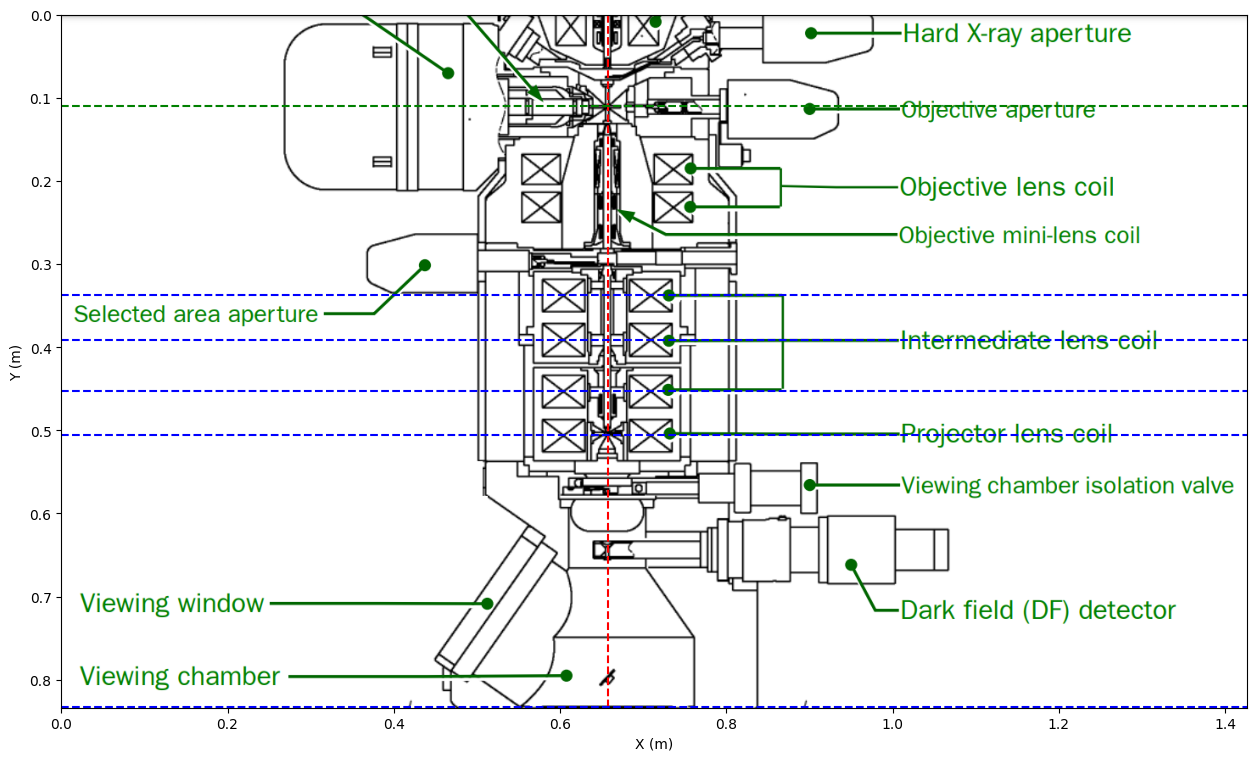

0.19030612244897963


In [3]:
f_obj_m = 0.0023 #m
Length_of_Chamber = 0.20 #m
Pixels_of_Chamber = 196 #pixels
scale = Pixel_Size = Length_of_Chamber/Pixels_of_Chamber #m

optical_axis_px = 644 #px
optical_axis_m = optical_axis_px * scale

sample_y_px = 107.5 #px
sample_x_px = optical_axis_px #px

sample_y_m = sample_y_px * scale
sample_x_m = sample_x_px * scale

z_sa_aperture_px = 294.0
z_il1_px = 331.0
z_il2_px = z_il1_px + 52
z_il3_px = z_il2_px + 61
z_pl1_px = z_il3_px + 52
z_det = z_pl1_px + 320

z_sa_aperture_m = z_sa_aperture_px * scale - sample_y_m
z_il1_m = z_il1_px * scale - sample_y_m
z_il2_m = z_il2_px * scale - sample_y_m
z_il3_m = z_il3_px * scale - sample_y_m
z_pl1_m = z_pl1_px * scale - sample_y_m
z_det_m = z_det * scale - sample_y_m

# Load the image
img = mpimg.imread("neoarm.png")
print(img.shape)

# Define scale
print(scale)
height, width = img.shape[:2]
extent = [0, width*scale, height*scale, 0]

# Plot the image
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(img, extent=extent, origin='upper')
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")

ax.vlines(optical_axis_m, 0, height*scale, color='r', linestyle='--', label='Optical Axis')
ax.hlines(sample_y_m, 0, width*scale, color='g', linestyle='--', label='Sample Y')
ax.hlines(z_il1_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl1')
ax.hlines(z_il2_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl2')
ax.hlines(z_il3_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl3')
ax.hlines(z_pl1_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='pl4')
ax.hlines(z_det_m + sample_y_m, 0, width*scale, color='b', linestyle='--', label='detector')
plt.show()

print(z_sa_aperture_m)



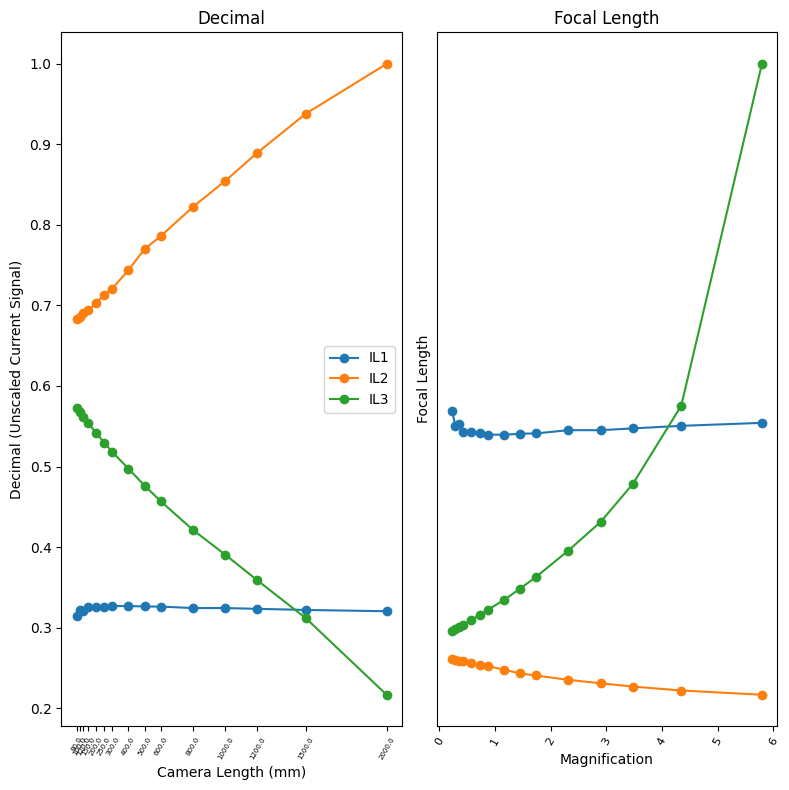

In [4]:
import json
import matplotlib.pyplot as plt
import numpy as np


with open(r'results_diff.json') as f:
    data = json.load(f)

lenses = (
 "IL1", 
 "IL2", 
 "IL3",
)


#mm to metres scale factor
scale = 1e-3
# Constants in the system. 
projector_lens_mag = M_pl1 = 150
objective_focal_length_m = f_obj_m = 0.0023 #m

#If camera length is just a magnification of the back focal plane,
#then L = f_obj * MIL1_IL2_IL3 * MProjector.

# If we assume that f_obj and M_projector are constants, then 
# the camera length value can be converted to a magnification value for the 
# IL1, IL2 and IL3 system.
# MIL1_IL2_IL3 = L / (f_obj * MProjector)
results = {}

MAG = 0
DEC = 1
CAM_MM = 2
CAM_M = 3
FOCAL_LENGTH_M = 4

for key in data.keys():
    for lens in data[key].keys():
        current = data[key][lens]
        if lens not in results:
            results[lens] = []
        
        camera_length_mm = float(key)
        camera_length_m = float(key) * scale #Default is in mm, convert to metres
        magnification = camera_length_m / (objective_focal_length_m * projector_lens_mag)
        decimal = int(current, 16) / 65535.0
        focal_length = 1/(decimal**2) if decimal != 0 else np.nan
        results[lens].append((magnification, decimal, camera_length_mm, camera_length_m, focal_length))

fig, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].tick_params(axis='x', rotation=60, labelsize=8)
ax[0].set_title('Decimal')
ax[0].set_xlabel('Camera Length (mm)')
ax[0].set_ylabel('Decimal (Unscaled Current Signal)')

for lens in lenses:
    cam_lengths_mm = np.array(results[lens])[:, CAM_MM]
    magnification = np.array(results[lens])[:, MAG]
    focal_length = np.array(results[lens])[:, FOCAL_LENGTH_M]
    decimal = np.array(results[lens])[:, DEC]
    ax[0].plot(cam_lengths_mm, decimal, label=lens, marker='o', linestyle='-')
    ax[1].plot(magnification, focal_length, label=lens, marker='o', linestyle='-')

ax[0].set_xticks(cam_lengths_mm)
ax[0].set_xticklabels(cam_lengths_mm)
ax[0].tick_params(axis='x', rotation=60, labelsize=5)
ax[0].legend(loc='center right')

ax[1].tick_params(axis='x', rotation=60, labelsize=8)
ax[1].set_title('Focal Length')
ax[1].set_xlabel('Magnification')
ax[1].set_ylabel('Focal Length')
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

Recalling the following relationships,
$$
\frac{1}{f} \propto {\text{I}^2} \\

\text{decimal} \propto I \\

f \propto \frac{1}{\text{decimal}^2}
$$
we have found a relationship between focal length and decimal value which we plot above. 

Also, Given the rotataion $\phi$ has the following relationship for a thin lens:

$$
\phi = \frac{\eta B_0}{2 \sqrt{\Psi}}
\quad\quad\text{and}\quad\quad
\frac{1}{f} = \frac{\eta^2 B_0^2}{8\,\Psi}
$$

where $\eta$ and $\Psi$ are charge-to-mass ratio and acceleration voltage, 
equating the two we find:

$$
\phi = \left(\frac{2}{f}\right)^\frac{1}{2}
$$

we see that in the thin lens approximation the rotation ($\phi$) is **inversely proportional to the square root of the focal length** \(f\).



In [5]:
from scipy.optimize import curve_fit

lenses = (
 "IL1", 
 "IL2", 
 "IL3",
)

def model_IL3(x, A, B, C, D, E):
    return (A * jnp.exp(B * x) + C * x ** 2 + D * x + E)

def model_IL1_IL2(x, a, b, c, d):
    return (a / x**2 + b * x **3 + c * x + d)

for lens in lenses:
    magnification = np.array(results[lens])[:, MAG]
    decimal = np.array(results[lens])[:, DEC]
    focal_length = 1/(decimal**2)

    if lens == "IL3":
        popt, pcov = curve_fit(model_IL3, magnification, focal_length, p0=(1.0, 0.01, 0.01, 0.01, 0.01))
        IL3_params = popt
        fitted_focal_length = model_IL3(magnification, *popt)
    else:
        popt, pcov = curve_fit(model_IL1_IL2, magnification, focal_length)
        fitted_focal_length = model_IL1_IL2(magnification, *popt)
        if lens == "IL2":
            IL2_params = popt
        else:
            IL1_params = popt

    ax[1].plot(magnification, fitted_focal_length, label=f'{lens} Fit')
    ax[1].legend()


In the case where only two lenses are changing, we have a very neat way to express the function for each focal length.

In [6]:
# Define symbols
f1, f2, f3, z1, z2, z3, z4, M, C, F = sp.symbols('f1 f2 f3 z1 z2 z3 z4 M C F', real=True)

# Define propagation and lens matrices with substituted values
Z1 = propagation_matrix(z1, xp=sp)
F1 = thin_lens_matrix(f1, xp=sp)
Z2 = propagation_matrix(z2, xp=sp)
F2 = thin_lens_matrix(f2, xp=sp)
Z3 = propagation_matrix(z3, xp=sp)

# Define lhs and rhs matrices
lhs = sp.Matrix([[M, 0], [-1/F, 1/M]])
rhs = Z3 * F2 * Z2 * F1 * Z1 

# Create equations from matrix equality
mat_eq = sp.Eq(lhs, rhs)

display(mat_eq.simplify())

# Extract individual equations
mat_eq_00 = sp.Eq(mat_eq.lhs[0, 0], mat_eq.rhs[0, 0])
mat_eq_01 = sp.Eq(mat_eq.lhs[0, 1], mat_eq.rhs[0, 1])
mat_eq_11 = sp.Eq(mat_eq.lhs[1, 1], mat_eq.rhs[1, 1])

#Write mat_eq_01 as an equation for f2
f2_eq = sp.solve(mat_eq_01, f2)[0].simplify()

#Substitute the equation for f2 into mat_eq_00
mat_eq_00 = mat_eq_00.subs(f2, f2_eq)

#Solve mat_eq_00 for f1
f1_eq = sp.solve(mat_eq_00, f1)[0].simplify()

display(sp.Eq(f1, f1_eq), sp.Eq(f2, f2_eq))


Eq(Matrix([
[   M,   0],
[-1/F, 1/M]]), Matrix([
[(f1*f2 - f1*z3 - f2*z3 - z2*(f2 - z3))/(f1*f2), (f1*f2*z3 + f1*z2*(f2 - z3) - z1*(-f1*f2 + f1*z3 + f2*z3 + z2*(f2 - z3)))/(f1*f2)],
[                       (-f1 - f2 + z2)/(f1*f2),                                       (f1*f2 - f1*z2 - z1*(f1 + f2 - z2))/(f1*f2)]]))

Eq(f1, M*z1*z2/(M*z1 + M*z2 + z3))

Eq(f2, z3*(f1*z1 + f1*z2 - z1*z2)/(f1*z1 + f1*z2 + f1*z3 - z1*z2 - z1*z3))

However, in the case of three lenses needing to change, the functions for focal length become a lot more complicated, and one can no longer write a solution for one focal length that is dependant on only magnification and distance values. 

In [7]:
# Define symbols
f1, f2, f3, z1, z2, z3, z4, M, C = sp.symbols('f1 f2 f3 z1 z2 z3 z4 M F', real=True, positive=True, nonzero=True)

# Define propagation and lens matrices with substituted values
Z1 = propagation_matrix(z1, xp=sp)
F1 = thin_lens_matrix(f1, xp=sp)
Z2 = propagation_matrix(z2, xp=sp)
F2 = thin_lens_matrix(f2, xp=sp)
Z3 = propagation_matrix(z3, xp=sp)
F3 = thin_lens_matrix(f3, xp=sp)
Z4 = propagation_matrix(z4, xp=sp)    

# Define lhs and rhs matrices
lhs = sp.Matrix([[M, 0], [-1/F, 1/M]])
rhs = Z4 * F3 * Z3 * F2 * Z2 * F1 * Z1

# Create equations from matrix equality
mat_eq = sp.Eq(lhs, rhs).simplify()

# Extract individual equations
mat_eq_00 = sp.Eq(mat_eq.lhs[0, 0], mat_eq.rhs[0, 0])
mat_eq_01 = sp.Eq(mat_eq.lhs[0, 1], mat_eq.rhs[0, 1])
mat_eq_11 = sp.Eq(mat_eq.lhs[1, 1], mat_eq.rhs[1, 1])

#Do a little bit of massaging to simplify them
#Clear denominators
mat_eq_00lhs = (mat_eq_00.lhs) * f1 * f2 * f3
mat_eq_00rhs = (mat_eq_00.rhs) * f1 * f2 * f3
mat_eq_01lhs = (mat_eq_01.lhs) * f1 * f2 * f3
mat_eq_01rhs = (mat_eq_01.rhs) * f1 * f2 * f3
mat_eq_11lhs = (mat_eq_11.lhs) * M * f1 * f2 * f3
mat_eq_11rhs = (mat_eq_11.rhs) * M * f1 * f2 * f3

eq1 = sp.Eq(mat_eq_00lhs - mat_eq_00rhs, 0.0)
eq2 = sp.Eq(mat_eq_01lhs - mat_eq_01rhs, 0.0)
eq3 = sp.Eq(mat_eq_11lhs - mat_eq_11rhs, 0.0)

display(eq1.simplify(), eq2.simplify(), eq3.simplify())

# display(sp.latex(mat_eq_00.simplify()), sp.latex(mat_eq_01.simplify()), sp.latex(mat_eq_11.simplify()))

Eq(M*f1*f2*f3 - f1*f2*f3 + f1*f2*z4 + f1*(f3*z4 + z3*(f3 - z4)) + f2*f3*z4 + f2*z3*(f3 - z4) - z2*(-f2*f3 + f2*z4 + f3*z4 + z3*(f3 - z4)), 0.0)

Eq(f1*f2*f3*z4 + f1*f2*z3*(f3 - z4) - f1*z2*(-f2*f3 + f2*z4 + f3*z4 + z3*(f3 - z4)) - z1*(-f1*f2*f3 + f1*f2*z4 + f1*(f3*z4 + z3*(f3 - z4)) + f2*f3*z4 + f2*z3*(f3 - z4) - z2*(-f2*f3 + f2*z4 + f3*z4 + z3*(f3 - z4))), 0.0)

Eq(M*(-f1*f2*f3 + f1*f2*z3 + f1*z2*(f2 + f3 - z3) + z1*(f1*f2 + f1*(f3 - z3) + f2*f3 - f2*z3 - z2*(f2 + f3 - z3))) + f1*f2*f3, 0.0)

I can think of 3 ways to go about solving this:

1. Input known $z$ values from the lab manual, with some estimates about what the projector lens is doing (magnification of -100), 
and for each of the 3 equations and a chosen magnification for the system, solve for $f_1$, $f_2$, $f_3$. Then compare to the functions generated from the hex values. Sympys solver 
should be able to handle this, because for each magnification, we have 3 equations and 3 unknowns, $f_1$, $f_2$, $f_3$. Sounds very simple. 



2. Input known $z$ values from the lab manual, with some estimates about what the projector lens is doing (magnification of -100), 
and for each of the 3 equations and a chosen magnification for the system, solve for $af_1$, $bf_2$, $cf_3$, where $f_1$, $f_2$ and $f_3$  are the known focal length functions of the lenses
that we have obtained from the hex values, and $a$, $b$, and $c$ are simple scale factors that scale the functions. Here we only try and find a scale value to move the functions up or down. 

3. Do not input known $z$ values from the manual, and instead try and find those $z$ positions, based on the focal length functions from the hex values. This should give unscaled $z$-ratios between the components, from which I can scale after with knowing an appropriate length scale. 

4. Check if sp.solve actually does anything.

1.Makes the fewest assumptions, as it says I know nothing about the focal lengths. ---Method 1 won't work because you need a good initial guess---

2.Uses all of the data we have. 

3.Seems slightly difficult, and again requires an optimization routine. 

Either way, all of this will have to be confirmed with experiment anyway I think!

Trying to solve via method 1, and seeing what comes out. 

In [8]:
import scipy

z_obj_m = 0.00233
M_pl1 = -150
pl1_z_img = z_det_m - z_pl1_m
pl1_z_obj = pl1_z_img / M_pl1
z_pl1_obj_m = M_pl1
z1_m = z_il1_m - (z_obj_m + f_obj_m) 
z2_m = z_il2_m - z_il1_m
z3_m = z_il3_m - z_il2_m
z4_m = (z_pl1_m + pl1_z_obj) - z_il3_m

pl1_f = (-1/pl1_z_obj + 1/z_pl1_obj_m)**-1

print("D1 (m) - Sample Plane to Objective Lens - ", z_obj_m)
print("D2 (m) - Objective Lens to IL1 - ", z_il1_m - z_obj_m)
print("D3 (m) - IL1 to IL2 - ", z2_m)
print("D4 (m) - IL2 to IL3 - ", z3_m)
print("D5 (m) - IL3 to PL1 - ", z_pl1_m - z_il3_m)
print("D6 (m) - PL1 to Image Plane - ", z_det_m - z_pl1_m)

D1 (m) - Sample Plane to Objective Lens -  0.00233
D2 (m) - Objective Lens to IL1 -  0.22573122448979596
D3 (m) - IL1 to IL2 -  0.05306122448979586
D4 (m) - IL2 to IL3 -  0.062244897959183754
D5 (m) - IL3 to PL1 -  0.05306122448979589
D6 (m) - PL1 to Image Plane -  0.326530612244898


In [9]:

num_values = {z1: z1_m, z2: z2_m, z3: z3_m, z4: z4_m}
eq1_num = eq1.subs(num_values)
eq2_num = eq2.subs(num_values)
eq3_num = eq3.subs(num_values)

eq1_lambda = sp.lambdify((M, f1, f2, f3), eq1_num.lhs, modules="numpy")
eq2_lambda = sp.lambdify((M, f1, f2, f3), eq2_num.lhs, modules="numpy")
eq3_lambda = sp.lambdify((M, f1, f2, f3), eq3_num.lhs, modules="numpy")

print(eq1_lambda(0,0,0,0))
print(eq2_lambda(0,0,0,0))
print(eq3_lambda(0,0,0,0))

IL1_f_data = model_IL1_IL2(magnification, *IL1_params)
IL2_f_data = model_IL1_IL2(magnification, *IL2_params)
IL3_f_data = model_IL3(magnification, *IL3_params)

max_val = np.max([IL1_f_data, IL2_f_data, IL3_f_data])
IL1_f_data = IL1_f_data / max_val
IL2_f_data = IL2_f_data / max_val
IL3_f_data = IL3_f_data / max_val

def forward(a, b, c):
    f1_vals = a * IL1_f_data
    f2_vals = b * IL2_f_data
    f3_vals = c * IL3_f_data

    return eq1_lambda(magnification, f1_vals, f2_vals, f3_vals), eq2_lambda(magnification, f1_vals, f2_vals, f3_vals), eq3_lambda(magnification, f1_vals, f2_vals, f3_vals)

def loss(params):
    A, B, D = forward(*params)
    return np.sum(A +  B + D) ** 2

params = np.array([IL1_f_data[0], IL2_f_data[0], IL3_f_data[0]])

opt = scipy.optimize.minimize(
    loss,
    params,
    method='Powell',
    options={'disp': True}
)
print(opt.x)

IL1_scale = opt.x[0]
IL2_scale = opt.x[1]
IL3_scale = opt.x[2]


0.000168060360337388
3.75499320983789e-05
0.0
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 45
[0.08643114 0.10163807 0.14343252]


[-2.65794998e-07  9.49275758e-07  1.77236611e-06  2.69485119e-06
  3.90881868e-06  4.97501793e-06  5.98131366e-06  7.90114320e-06
  9.72469783e-06  1.14458231e-05  1.45277980e-05  1.71017736e-05
  1.93085401e-05  2.31639888e-05  5.31915153e-05]
[-1.29877488e-06 -1.05354509e-06 -9.06957029e-07 -7.67264699e-07
 -6.20724110e-07 -5.16594682e-07 -4.31629492e-07 -2.93349433e-07
 -1.84552594e-07 -1.00576867e-07 -7.82453184e-10  1.72356011e-08
 -3.07638489e-08 -1.69823166e-07  1.14614432e-07]
[-5.59283631e-06 -5.98871704e-06 -6.62047322e-06 -7.77598179e-06
 -9.83633820e-06 -1.17714837e-05 -1.34500073e-05 -1.58977352e-05
 -1.71567017e-05 -1.73875126e-05 -1.56685390e-05 -1.26792211e-05
 -1.03023420e-05 -1.10351355e-05 -8.97461518e-06]


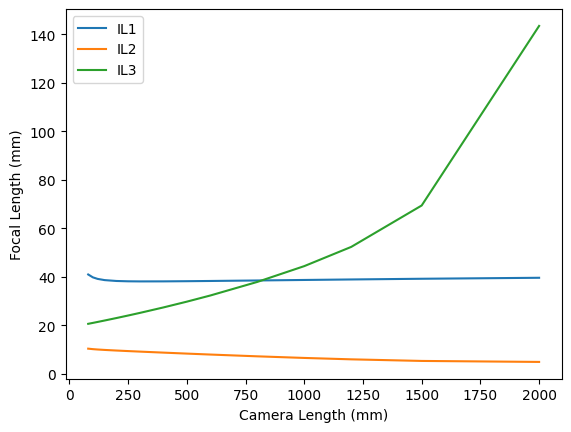

In [10]:
f1_physical = opt.x[0] * IL1_f_data
f2_physical = opt.x[1] * IL2_f_data
f3_physical = opt.x[2] * IL3_f_data

print(eq1_lambda(magnification, f1_physical, f2_physical, f3_physical))
print(eq2_lambda(magnification, f1_physical, f2_physical, f3_physical))
print(eq3_lambda(magnification, f1_physical, f2_physical, f3_physical))

plt.figure()
plt.plot((magnification * f_obj_m * -M_pl1) * 1000, f1_physical * 1000, label='IL1')
plt.plot((magnification * f_obj_m * -M_pl1) * 1000, f2_physical * 1000, label='IL2')
plt.plot((magnification * f_obj_m * -M_pl1) * 1000, f3_physical * 1000, label='IL3')
plt.xlabel('Camera Length (mm)')
plt.ylabel('Focal Length (mm)')
plt.legend()

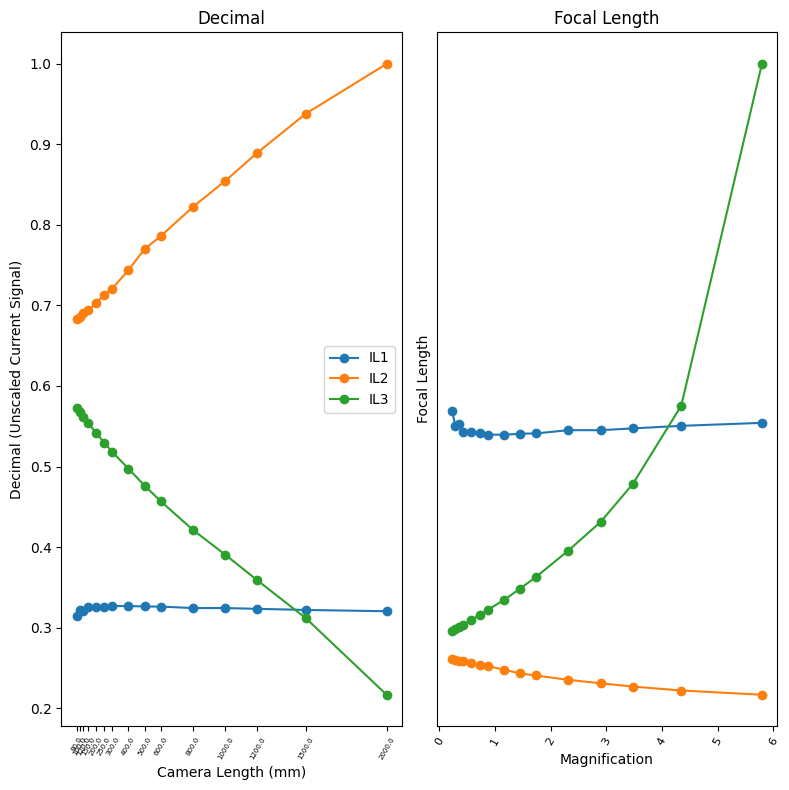

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].tick_params(axis='x', rotation=60, labelsize=8)
ax[0].set_title('Decimal')
ax[0].set_xlabel('Camera Length (mm)')
ax[0].set_ylabel('Decimal (Unscaled Current Signal)')

for lens in lenses:
    cam_lengths_mm = np.array(results[lens])[:, CAM_MM]
    magnification = np.array(results[lens])[:, MAG]
    focal_length = np.array(results[lens])[:, FOCAL_LENGTH_M]
    decimal = np.array(results[lens])[:, DEC]
    ax[0].plot(cam_lengths_mm, decimal, label=lens, marker='o', linestyle='-')
    ax[1].plot(magnification, focal_length, label=lens, marker='o', linestyle='-')

ax[0].set_xticks(cam_lengths_mm)
ax[0].set_xticklabels(cam_lengths_mm)
ax[0].tick_params(axis='x', rotation=60, labelsize=5)
ax[0].legend(loc='center right')

ax[1].tick_params(axis='x', rotation=60, labelsize=8)
ax[1].set_title('Focal Length')
ax[1].set_xlabel('Magnification')
ax[1].set_ylabel('Focal Length')
ax[1].set_yticks([])

plt.tight_layout()
plt.show()